# Results

The script below runs the model, outputs the results, and generates figures.

Last updated: 6 May 2020

In [2]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
os.chdir('..')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

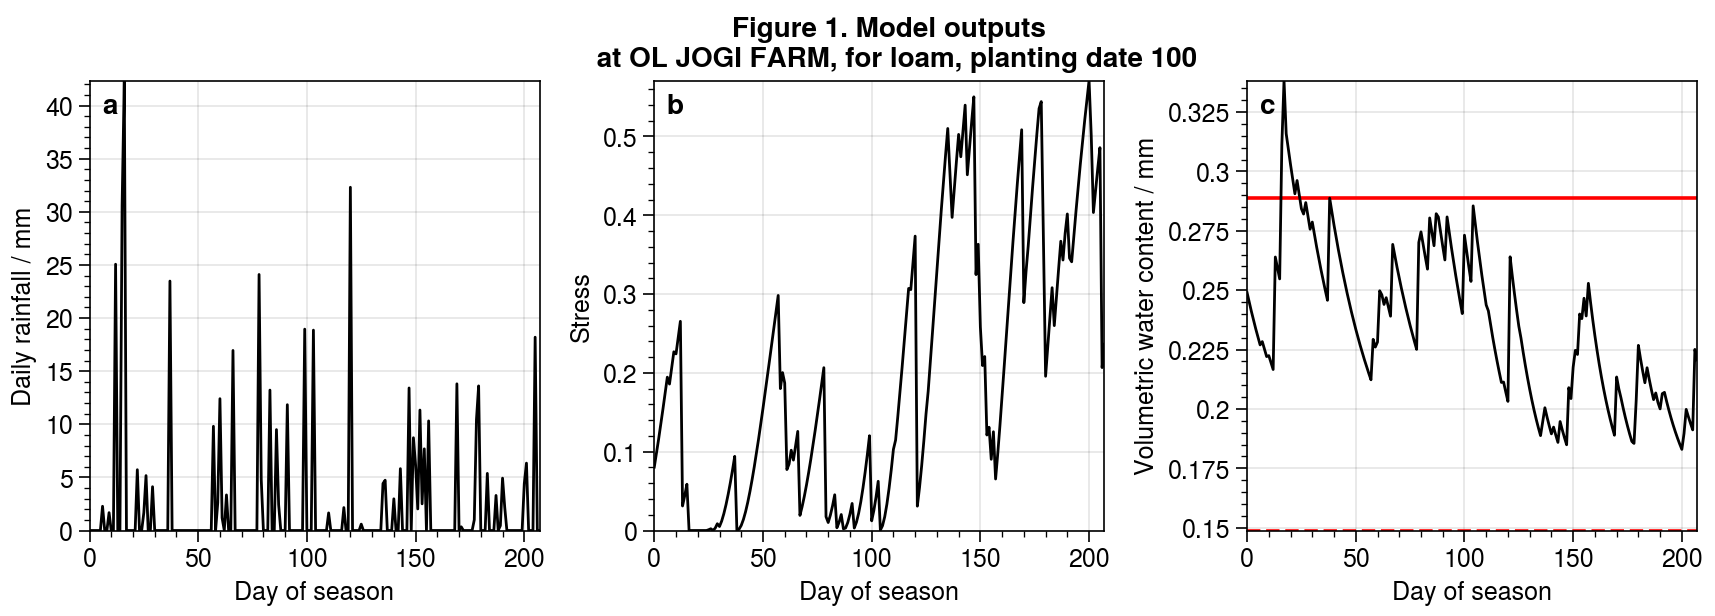

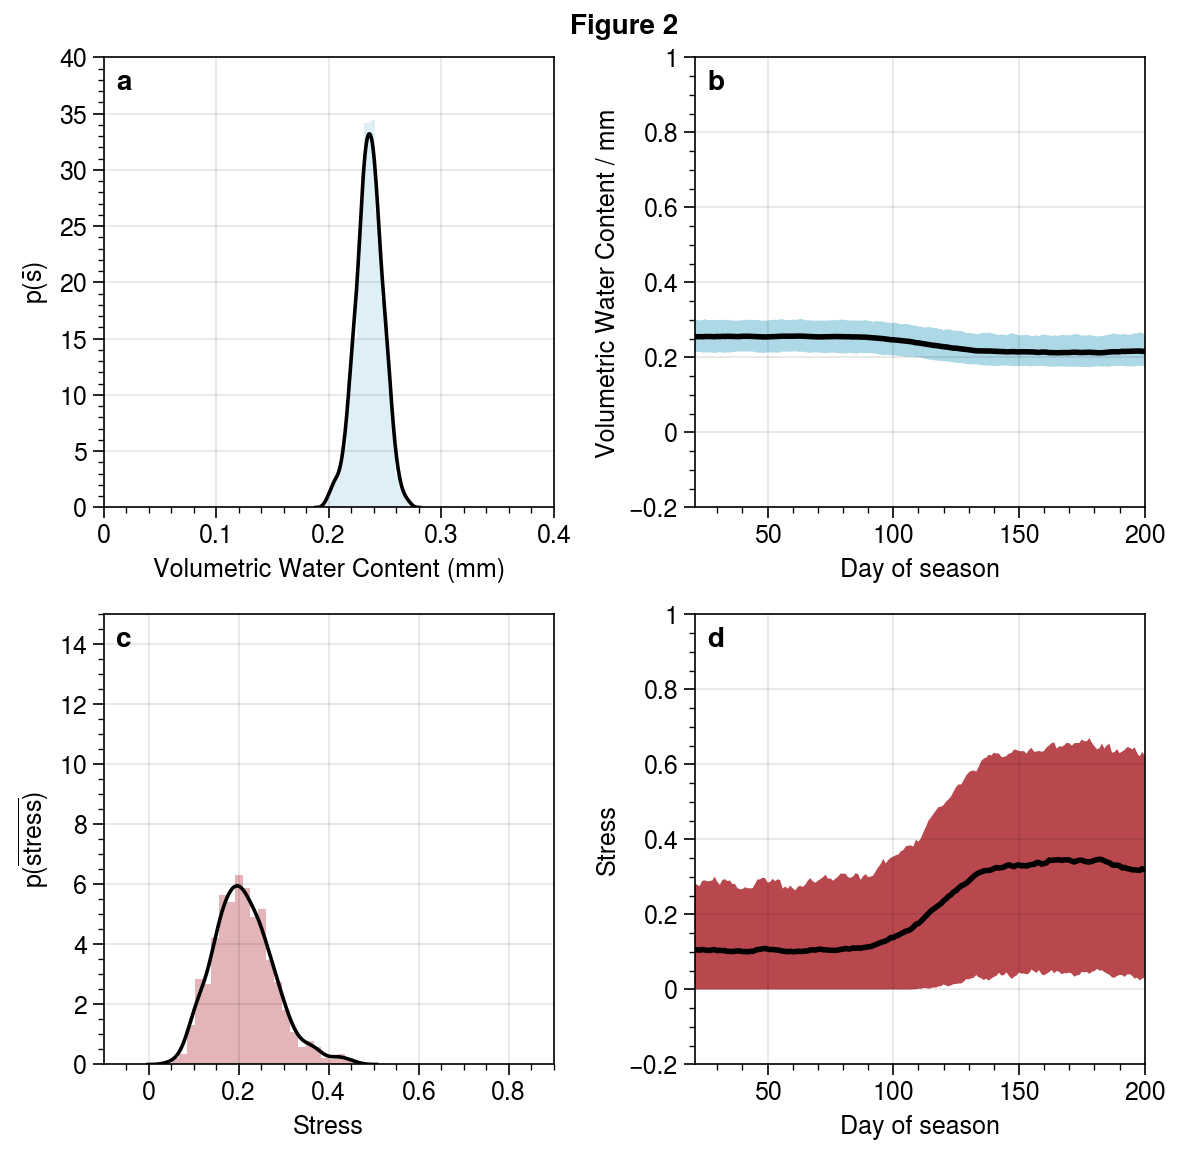

In [3]:
# splitting figure 1 into two figures

def figure1_2(n_sim = 1000, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = 21 
    end = start + lgp
    
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Make figures: 
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # , share=0, spanx=1, sharey=0
    axs.format(
        abc=True, abcloc='ul', suptitle='Figure 1. Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )#,
    #   xlabel='s', ylabel='ylabel'
    #)
    
    # Figure 1a: Rainfall from one simulation
    axs[0,0].plot(output[0]['R'], color='k', lw=1) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm') #
    axs[0,0].format(xlabel='Day of season')
    
    # Figure 1b: Stress from one simulation
    axs[0,1].plot(output[0]['stress'], color='k', lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Stress')
    axs[0,1].format(xlabel='Day of season')
    
    # Figure 1c: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity

    # we have the function theta already but I'm not sure that we call on that.

    vwc = output[0]['s']*Soil(texture).n
    # convert s_star and sw
    _sstar = crop.s_star*Soil(texture).n
    _sw = crop.sw*Soil(texture).n
    
    plt.axhline(y=_sw, color='r', linestyle='--')
    plt.axhline(y=_sstar, color='r', linestyle='-')
    #xs = np.linspace(1,len(output[0]),1)
    #horiz_line_data = np.array([_sw for i in xrange(len(xs))])
    #plt.plot(xs, horiz_line_data, 'r--') 
    
    axs[0,2].plot(vwc, color='k', lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Volumetric water content / mm')
    axs[0,2].format(xlabel='Day of season')

    # Second set
    f, axs = plot.subplots(nrows=2, ncols=2, share=0)
    axs.format(abc=True, abcloc='ul', suptitle='Figure 2')
    
    
    # Figure b: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': True},hist_kws={"color": 'lightblue'}) 
    ax.format(xlim=(0, 0.4), ylim=(0, 40))
    ax.format(ylabel=r'p($\bar{s}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color='k',**{'kde': True, 'hist': True},hist_kws={"color": '#b9484e'}) #color='orange', 
    # other hist_kws args: "histtype": "step", "linewidth": 3,
    #                        "alpha": 1, 
    ax.format(xlim=(-0.1, 0.9), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure e: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
    avg_daily = avg_daily*Soil(texture).n
    avg_daily_t = avg_daily.T
    daily_mean = avg_daily.mean(axis=1)
    daily_mean = daily_mean
    data = np.array(daily_mean)
    
    axs[0,1].plot(daily_mean, color='k', lw=2)

    x = np.arange(0+21, len(daily_mean)+21, 1) 

    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue')
    #plt.ylim(-0.2, 1)
    axs[0,1].format(ylim=(-0.2, 1)) #xlim=(0.3, 0.8), 
    #axs[0,2].format(ylabel='Soil moisture / mm')
    axs[0,1].format(xlabel='Day of season')
    #plt.ylabel('Soil moisture / mm')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean = daily_mean
    
    axs[1,1].plot(daily_mean, color='k', lw=2)

    x = np.arange(0+21, len(daily_mean)+21, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9],facecolor='#b9484e') #'#fdaa48'
    #plt.ylim(-0.2, 1)
    axs[1,1].format(ylim=(-0.2, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    axs[1,1].format(xlabel='Day of season')
    
    return int(lgp), avg_s, output, start, end, crop

lgp, avg_s, output, start, end, crop = figure1_2()

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/proplot/wrappers.py:2439: UserWarning: The handle <matplotlib.lines.Line2D object at 0x11e5ebb50> has a label of '_line2' which cannot be automatically added to the legend.
  leg = mlegend.Legend(self, *zip(*pairs), ncol=ncol, loc=loc, **kwargs)


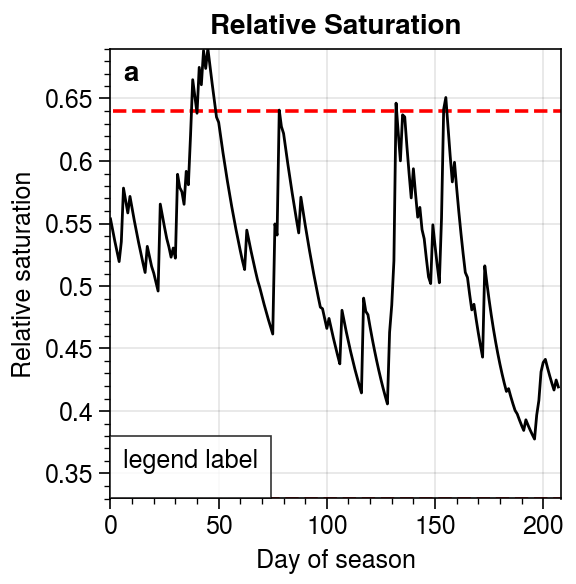

In [83]:
# make one graph of relative saturaiton with annotations
f, axs = plot.subplots(nrows = 1, ncols = 1, share=0) # , share=0, spanx=1, sharey=0
axs.format(
    abc=True, abcloc='ul', suptitle='Relative Saturation')#,

vwc = output[0]['s']
# convert s_star and sw
_sstar = crop.s_star
_sw = crop.sw

#plt.axhline(y=_sw, color='r', linestyle='--')
#plt.axhline(y=_sstar, color='r', linestyle='-')
xs = np.linspace(1,len(output[0]),len(output[0]))
horiz_line_data = np.array([_sw for i in range(len(xs))])
axs.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([_sstar for i in range(len(xs))])
axs.plot(xs, horiz_line_data, 'r--') 

hs = axs.plot(vwc, color='k', lw=1, legend_kw={'order': 'F', 'title': 'column major'}) #color='lightblue',lw=1, 
axs.format(ylabel='Relative saturation')
axs.format(xlabel='Day of season')

# add legend
axs.legend(hs, loc='ll', label='legend label')

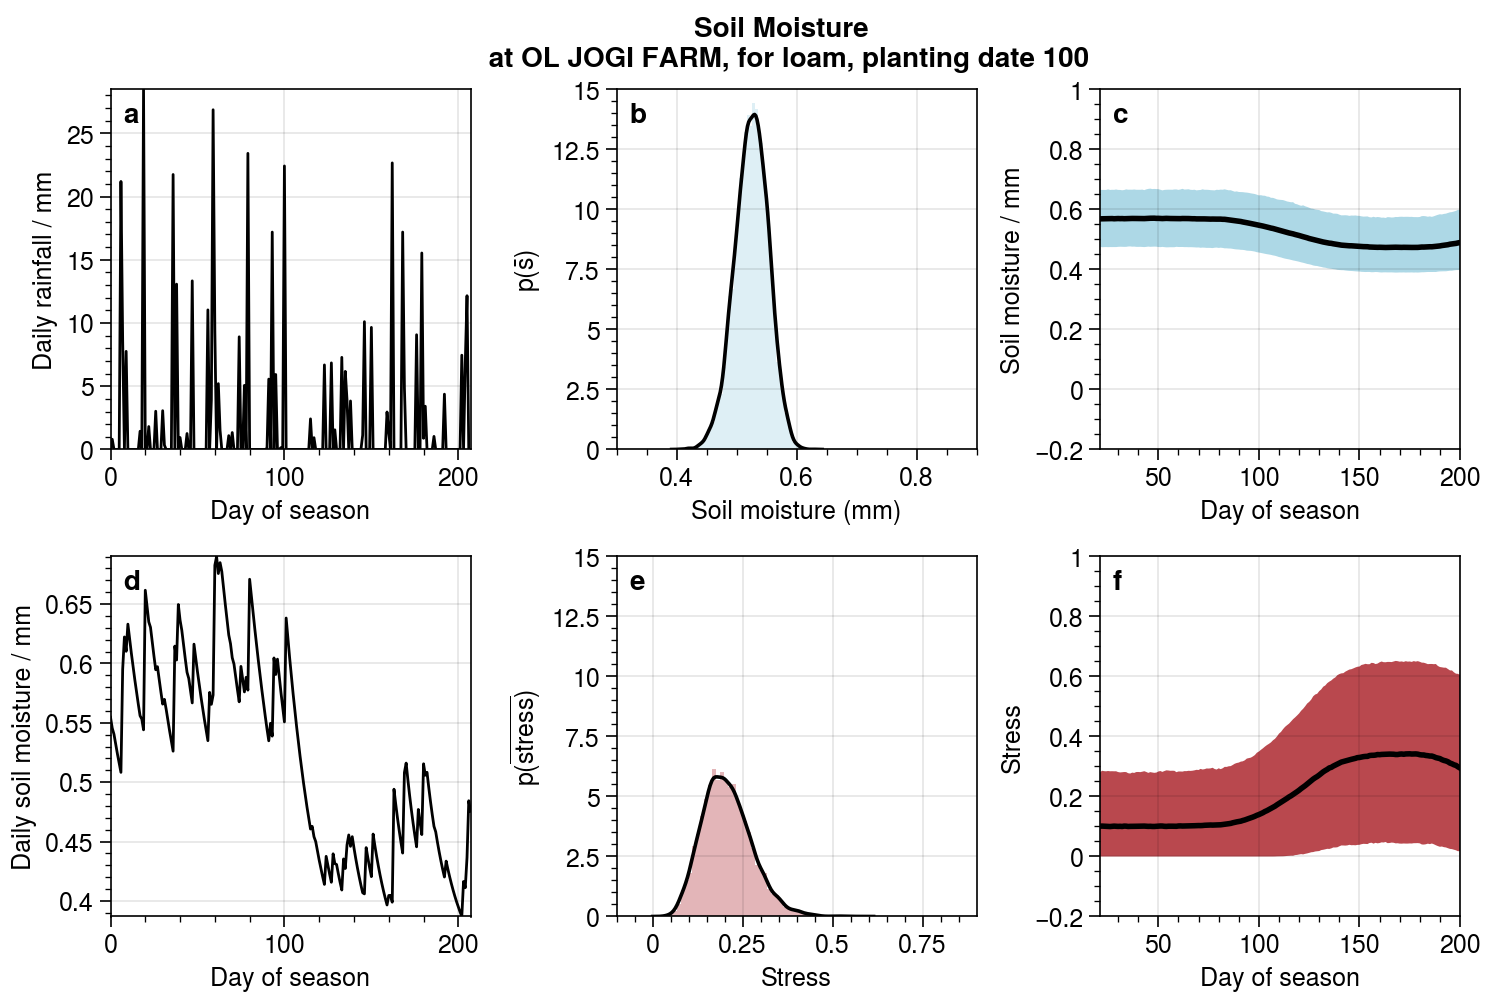

In [39]:
# Updated figure 1

def figure1(n_sim = 1000, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = 21 
    end = start + lgp
    
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Make figures: 
    f, axs = plot.subplots(nrows = 2, ncols = 3, axwidth=1.8, share=0) # , share=0, spanx=1, sharey=0
    axs.format(
        abc=True, abcloc='ul', suptitle='Soil Moisture \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )#,
    #   xlabel='s', ylabel='ylabel'
    #)
    
    # Figure a: Rainfall from one simulation
    axs[0,0].plot(output[0]['R'], color='k', lw=1) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm') #
    axs[0,0].format(xlabel='Day of season')
    
    # Figure d: Soil moisture from one simulation
    axs[1,0].plot(output[0]['s'], color='k', lw=1) #color='lightblue',lw=1, 
    axs[1,0].format(ylabel='Relative saturation / s')
    axs[1,0].format(xlabel='Day of season')

    # Figure b: Soil moisture distribution
    ax = axs[0,1]
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': True},hist_kws={"color": 'lightblue'}) 
    ax.format(xlim=(0.3, 0.9), ylim=(0, 15))
    ax.format(ylabel=r'p($\bar{s}$)')
    ax.format(xlabel='Relative saturation / s')
    
    # Figure c: Stress distribution
    ax = axs[1,1]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color='k',**{'kde': True, 'hist': True},hist_kws={"color": '#b9484e'}) #color='orange', 
    # other hist_kws args: "histtype": "step", "linewidth": 3,
    #                        "alpha": 1, 
    ax.format(xlim=(-0.1, 0.9), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure e: Soil moisture time series
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
    avg_daily_t = avg_daily.T
    daily_mean = avg_daily.mean(axis=1)
    daily_mean = daily_mean
    data = np.array(daily_mean)
    
    axs[0,2].plot(daily_mean, color='k', lw=2) 

    x = np.arange(0+21, len(daily_mean)+21, 1) 

    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,2].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue')
    #plt.ylim(-0.2, 1)
    axs[0,2].format(ylim=(-0.2, 1)) #xlim=(0.3, 0.8), 
    #axs[0,2].format(ylabel='Soil moisture / mm')
    axs[0,2].format(xlabel='Day of season')
    #plt.ylabel('Soil moisture / mm')
    axs[0,2].format(ylabel='Relative saturation / s')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean = daily_mean
    
    axs[1,2].plot(daily_mean, color='k', lw=2)

    x = np.arange(0+21, len(daily_mean)+21, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,2].fill_between(x, quant[0.1], quant[0.9],facecolor='#b9484e') #'#fdaa48'
    #plt.ylim(-0.2, 1)
    axs[1,2].format(ylim=(-0.2, 1))
    plt.ylabel('Stress')
    axs[1,2].format(ylabel='Stress')
    axs[1,2].format(xlabel='Day of season')
    
    #return int(lgp), avg_s, output, start, end

#lgp, avg_s, output, start, end = figure1()
figure1()

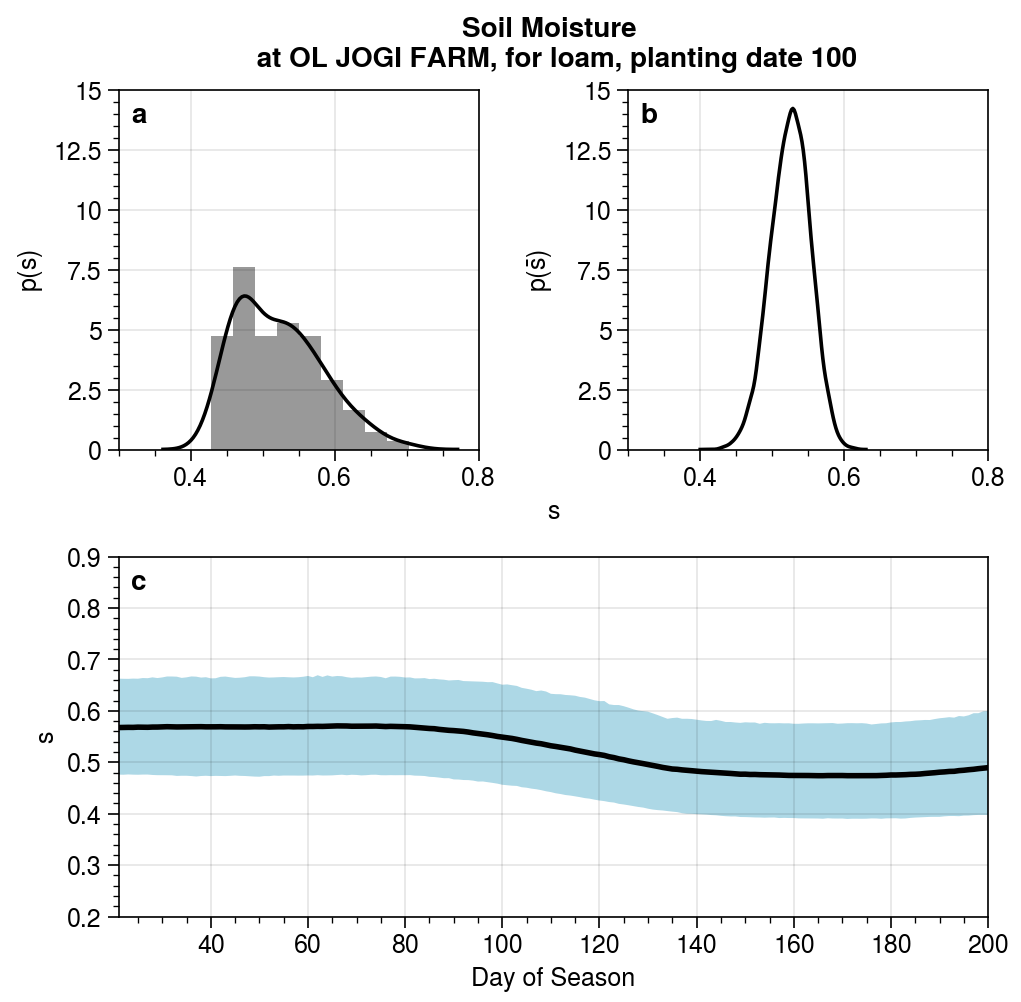

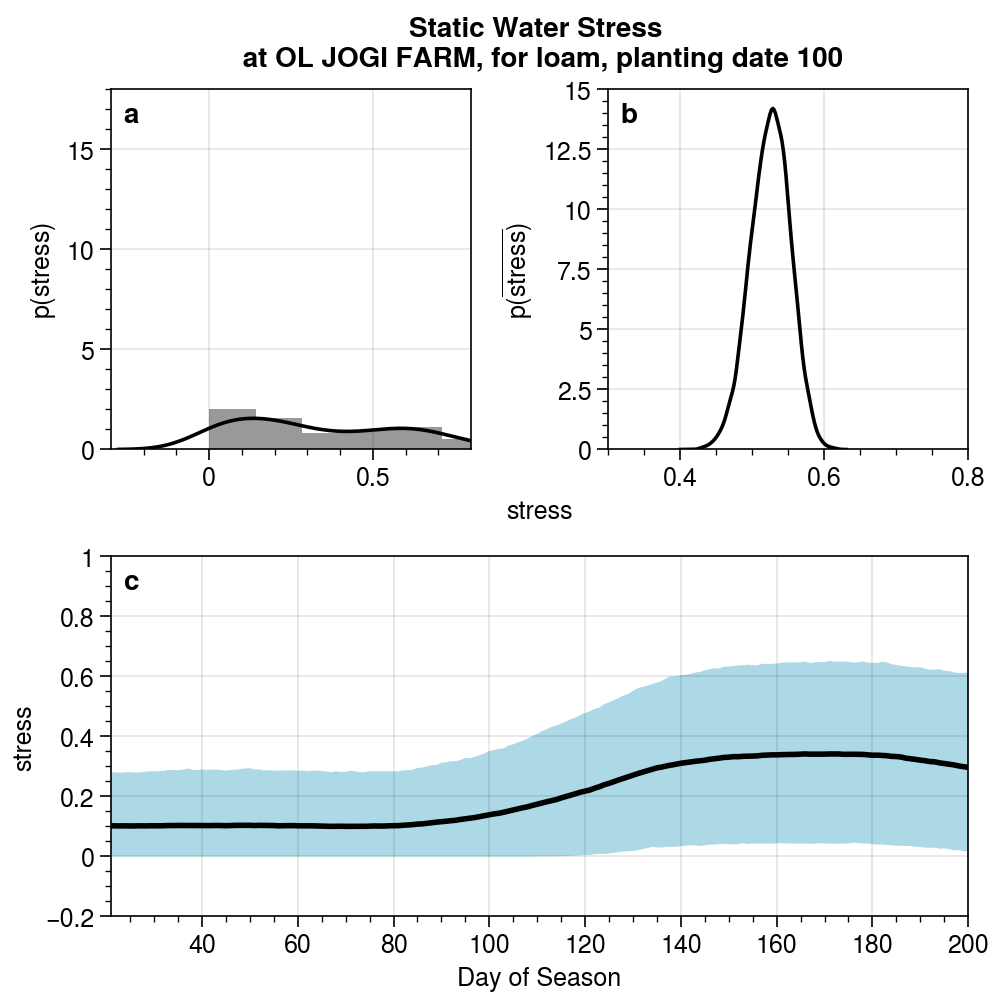

In [6]:
# Figs 1 and 2 using proplot

def soil_moisture_pdf(n_sim = 10000, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = 21 
    end = start + lgp
    
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # SOIL MOISTURE
    # Part 6. Make figures: 
    # Complex grid
    array = [  # the "picture"; 1 == subplot a, 2 == subplot b, etc.
        [1, 1, 2, 2],
        [3, 3, 3, 3],
    ]
    f, axs = plot.subplots(array, axwidth=1.8, share=0, spanx=1, sharey=0)
    axs.format(
        abc=True, abcloc='ul', suptitle='Soil Moisture \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim,
        xlabel='s', ylabel='ylabel'
    )

    axs[0,0].format(ylabel=r'p($s$)')
    axs[0,1].format(ylabel=r'p($\bar{s}$)')
    
    # (a) plot the soil moisture for just one simulation
    num_of_sim = 0
    s_sim = output[num_of_sim][start:end]['s']
    data = np.array(s_sim)
    ax = axs[0]
    sns.distplot(data, ax=ax, color='k', **{'kde': True, 'hist': True}) 
    ax.format(xlim=(0.3, 0.8), ylim=(0, 15))
    
    # (b)
    ax = axs[1]
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': False}) 
    ax.format(xlim=(0.3, 0.8), ylim=(0, 15))
    
    # (c) plot avg s.m. from each day's s.m.
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
    avg_daily_t = avg_daily.T
    daily_mean = avg_daily.mean(axis=1)
    daily_mean = daily_mean
    data = np.array(daily_mean)
    
    axs[2].plot(daily_mean, color='k', lw=2) 
    axs[2].format(ylabel='test')
    plt.xlabel('Day of Season')

    x = np.arange(0+21, len(daily_mean)+21, 1) 

    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[2].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue')
    plt.ylim(0.2, 0.9)
    plt.ylabel('s')
    
    plt.show()
    
    # STATIC WATER STRESS
    # Complex grid
    array = [  # the "picture"; 1 == subplot a, 2 == subplot b, etc.
        [1, 1, 2, 2],
        [3, 3, 3, 3],
    ]
    f, axs = plot.subplots(array, axwidth=1.8, share=0, spanx=1, sharey=0)
    axs.format(
        abc=True, abcloc='ul', suptitle='Static Water Stress \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim,
        xlabel='stress', ylabel='ylabel'
    )

    axs[0,0].format(ylabel=r'p($stress$)')
    axs[0,1].format(ylabel=r'p($\overline{stress}$)')
    
    # fig a
    num_of_sim = 100
    s_sim = output[num_of_sim][start:end]['stress']
    data = np.array(s_sim)
    ax = axs[0]
    sns.distplot(data, ax=ax, color='k', **{'kde': True, 'hist': True})#.set(xlim=0) # bins=None,, label="lgp=%d" %lgp
    ax.format(xlim=(-0.3, 0.8), ylim=(0, 18))
    
    # fig b
    ax = axs[1]
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': False}) 
    ax.format(xlim=(0.3, 0.8), ylim=(0, 15))
    
    # fig c
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean = daily_mean
    
    axs[2].plot(daily_mean, color='k', lw=2)
    plt.xlabel('Day of Season')

    x = np.arange(0+21, len(daily_mean)+21, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[2].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue') 
    plt.ylim(-0.2, 1)
    plt.ylabel('stress')
    
    return int(lgp), avg_s, output, start, end

lgp, avg_s, output, start, end = soil_moisture_pdf()

Notes: How to bound the kde fit on static water stress to zero?
* [DataCamp](https://www.datacamp.com/community/tutorials/probability-distributions-python) article talks about distributions and exponential one still has curve that overflows to zero.
* [Stackoverflow](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python) says only option is to cut the axis limits to zero. Also [here](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python). Explanation for why you can get negative values from a positive density kernel density estimation, [stackexchange](https://stats.stackexchange.com/questions/109549/negative-density-for-non-negative-variables).